# SARIMAX (Seasonal ARIMA with eXogenous variables) Model

This notebook demonstrates the implementation of the SARIMAX (Seasonal ARIMA with eXogenous variables) Model.

SARIMAX extends the SARIMA model by incorporating exogenous variables that influence the target variable. It is particularly useful for forecasting time series data with both seasonal patterns and external factors. The SARIMAX model combines:

- **Seasonal ARIMA Components**:
  - **Autoregression (AR)**: Captures the relationship between an observation and its previous values.
  - **Differencing (I)**: Removes trends and seasonality to make the series stationary.
  - **Moving Average (MA)**: Accounts for the relationship between an observation and past forecast errors.
  - **Seasonality (SAR, SI, SMA)**: Handles recurring patterns at regular intervals.
- **Exogenous Variables (X)**:
  - Incorporates external factors that may influence the target variable for more accurate predictions.

# Step 1 & 2: Importing Libraries and Loading Dataset

### Step 1: Loading the Dataset
- I used `pandas` to load the dataset from `'../datasets/master_dataset/master_dataset.xlsx'`.
- The data was stored in the variable `data` for further processing.

### Step 2: Defining Target and Exogenous Variables
- **Target Variable**: `Quantity`, the main column to forecast.
- **Exogenous Variables**: `Clicks` and `Impressions`, external factors that may influence the target variable.
- These variables will help the SARIMAX model consider both historical patterns and external influences for better predictions.


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Step 1: Load the dataset
data = pd.read_excel('../datasets/master_dataset/master_dataset.xlsx')

# Step 2: Define the main time series column and exogenous variables
target_column = "Quantity"  # The column we want to forecast
exogenous_columns = ["Clicks", "Impressions"]  # Exogenous variables

# Step 3: Preparing the Data

- **Cleaning the Data**:
  - I removed missing values from the target column (`Quantity`) and exogenous variables (`Clicks`, `Impressions`) using `.dropna()`.

- **Aligning Data Lengths**:
  - To ensure compatibility, I matched the lengths of the target and exogenous variables by slicing both to the minimum length.

- **Inspecting the Data**:
  - I displayed the first 5 rows of the cleaned target column and exogenous variables to verify their alignment and readiness for modeling.


In [2]:
# Step 3: Prepare the data
time_series = data[target_column].dropna()  # Remove missing values in the target column
exogenous_data = data[exogenous_columns].dropna()  # Drop missing values in exogenous variables

# Ensure the lengths of target and exogenous variables match
min_length = min(len(time_series), len(exogenous_data))
time_series = time_series.iloc[:min_length]
exogenous_data = exogenous_data.iloc[:min_length]

# Display first few rows of data
print(f"First 5 rows of the target column '{target_column}':\n", time_series.head())
print(f"First 5 rows of exogenous variables:\n", exogenous_data.head())

First 5 rows of the target column 'Quantity':
 0    14
1    10
2    13
3    22
4    33
Name: Quantity, dtype: int64
First 5 rows of exogenous variables:
    Clicks  Impressions
0     445          620
1     433          890
2     424          851
3     427          881
4     451          678


# Step 4: Checking Stationarity of the Target Column

- **Stationarity Test**:
  - I used the Augmented Dickey-Fuller (ADF) test to check if the target column (`Quantity`) was stationary.
  - The test outputs a **test statistic** and a **p-value**:
    - If `p-value > 0.05`: The series is non-stationary, and I applied differencing using `.diff()` to make it stationary.
    - If `p-value <= 0.05`: The series is already stationary, so no differencing was needed.

- **Aligning Exogenous Data**:
  - For differenced data, I adjusted the exogenous variables by removing the first row to ensure alignment with the differenced target column.

This step ensures the target series is stationary, a critical requirement for accurate SARIMAX modeling.


In [3]:
# Step 4: Check stationarity of the target column
adf_test = adfuller(time_series)
print(f"Dickey-Fuller Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] > 0.05:
    print(f"The target column '{target_column}' is non-stationary. Applying differencing...")
    time_series_diff = time_series.diff().dropna()  # Make the series stationary

    # Align exogenous data with differenced series
    exogenous_data = exogenous_data.iloc[1:].reset_index(drop=True)
else:
    print(f"The target column '{target_column}' is stationary.")
    time_series_diff = time_series

Dickey-Fuller Test Statistic: -4.445717448758575
p-value: 0.00024615679644112006
The target column 'Quantity' is stationary.


# Step 5: Fitting the SARIMAX Model

- **Defining Model Parameters**:
  - I set the non-seasonal parameters `(p, d, q)` to `(1, 1, 1)`, which control:
    - `p`: Autoregressive terms.
    - `d`: Differencing to achieve stationarity.
    - `q`: Moving average terms.
  - I defined the seasonal parameters `(P, D, Q, s)` as `(1, 1, 1, 12)`, where:
    - `P`, `D`, `Q`: Seasonal counterparts of `p`, `d`, `q`.
    - `s = 12`: Indicates a monthly seasonality.

- **Fitting the Model**:
  - I used the `SARIMAX` module to fit the model:
    - `time_series_diff`: The stationary target series as the dependent variable.
    - `exog=exogenous_data`: The exogenous variables to account for external factors.
  - The `.fit()` method trained the model.

In [4]:
# Step 5: Fit the SARIMAX Model
# Set SARIMAX model parameters (p, d, q, P, D, Q, s)
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters (s = 12 for monthly data, adjust as needed)
sarimax_model = SARIMAX(time_series_diff, exog=exogenous_data, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

# Print the model summary
print("SARIMAX Model Summary:")
print(sarimax_model.summary())

SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -630.969
Date:                            Wed, 27 Nov 2024   AIC                           1275.938
Time:                                    00:29:48   BIC                           1298.991
Sample:                                         0   HQIC                          1285.268
                                            - 212                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Clicks          0.0191      0.006      3.426      0.001       0.008       0.030
Impressio

c:\Users\nitin\OneDrive\Documents\Infosys Springboard Internship Files\NitinMishra-Infosys-Nov24\python files\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Step 6: Making Predictions and Comparing Results

- **Generating Predictions**:
  - I used the `.predict()` method of the SARIMAX model to generate predictions for the observed time series:
    - Predictions were made from `start=1` to `end=len(time_series_diff) - 1`.
    - Corresponding exogenous variables (`exogenous_data.iloc[1:]`) were provided to align with the predictions.

- **Creating a Comparison**:
  - I combined the **actual** and **predicted** values into a `pandas` DataFrame to compare the performance of the SARIMAX model.
  - The first 5 rows of the comparison were displayed for a quick inspection.

- **Visualizing Results**:
  - I plotted the **Actual** vs. **Predicted** values:
    - The actual values were plotted in blue to represent the observed data.
    - The predicted values were plotted in red with a dashed line to indicate the model's predictions.
  - This visualization highlights how well the SARIMAX model fits the observed data.

This step evaluates the model's performance by comparing predicted values with the actual time series, helping validate its accuracy.



First 5 rows of Actual vs Predicted for 'Quantity':
    Actual  Predicted
1      10  14.258716
2      13   9.757525
3      22  13.111509
4      33  22.091479
5      12  33.152110


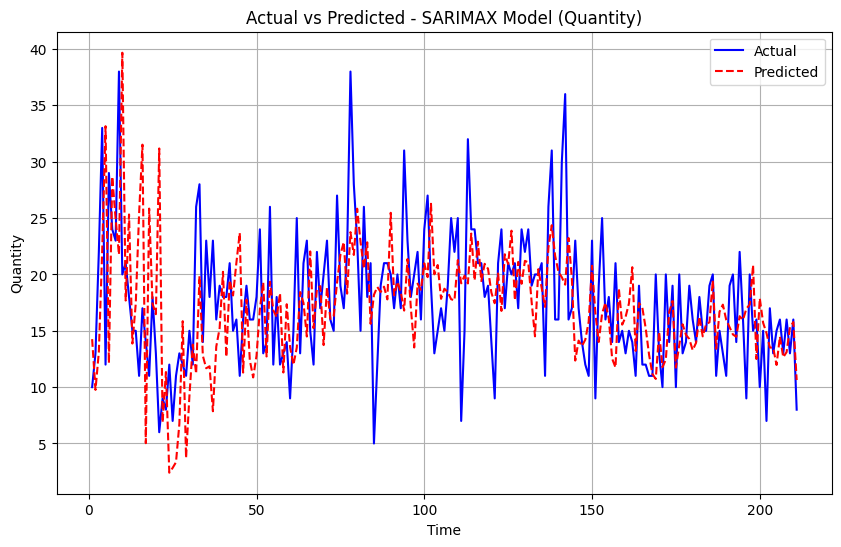

In [5]:
# Step 6: Make predictions
predictions = sarimax_model.predict(start=1, end=len(time_series_diff) - 1, exog=exogenous_data.iloc[1:])

# Combine actual and predicted values for comparison
comparison = pd.DataFrame({
    "Actual": time_series_diff[1:].values,
    "Predicted": predictions
})

# Display first 5 rows of the comparison
print(f"\nFirst 5 rows of Actual vs Predicted for '{target_column}':\n", comparison.head())

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(comparison["Actual"], label="Actual", color="blue")
plt.plot(comparison["Predicted"], label="Predicted", color="red", linestyle="--")
plt.title(f"Actual vs Predicted - SARIMAX Model ({target_column})")
plt.xlabel("Time")
plt.ylabel(target_column)
plt.legend()
plt.grid()
plt.show()

# Step 7: Forecasting Future Values

- **Defining Forecast Horizon**:
  - I set the number of steps for forecasting to `5`, predicting the next 5 future values of the target variable.

- **Preparing Exogenous Data**:
  - I extracted the last 5 rows of exogenous variables (`future_exog`) to provide the model with the most recent external factors for forecasting.

- **Generating Forecasts**:
  - I used the `.forecast()` method of the SARIMAX model to predict future values:
    - The `future_exog` data was passed to account for external influences during forecasting.
  - The forecasted values were printed for review.

This step uses the trained SARIMAX model to predict future values while considering external factors, enabling actionable insights for planning and decision-making.


In [6]:
# Step 7: Forecast future values
forecast_steps = 5  # Number of steps to forecast
future_exog = exogenous_data.iloc[-forecast_steps:]  # Use recent exogenous data
forecast = sarimax_model.forecast(steps=forecast_steps, exog=future_exog)

print(f"\nForecasted Values for '{target_column}':\n", forecast)


Forecasted Values for 'Quantity':
 212    13.664102
213    14.776769
214    12.471031
215    13.474996
216    11.012042
Name: predicted_mean, dtype: float64


# Step 8: Displaying Forecast Results

- **Creating Future Index**:
  - I generated a range of indices to represent the time points for the forecasted values:
    - This index starts from the end of the original time series and extends for the number of forecast steps.

- **Visualizing Forecasts**:
  - I plotted the original time series (`time_series_diff`) alongside the forecasted values:
    - The original series was plotted in blue to show the historical data.
    - The forecasted values were plotted in red with a dashed line to highlight the model's predictions.
  - The plot includes:
    - A title indicating the SARIMAX forecast results.
    - Labels for the x-axis (`Time`) and y-axis (`Quantity`).
    - A legend to distinguish between the original and forecasted values.

This step provides a clear visual comparison of historical data and forecasted trends, making it easy to interpret the SARIMAX model's predictions.


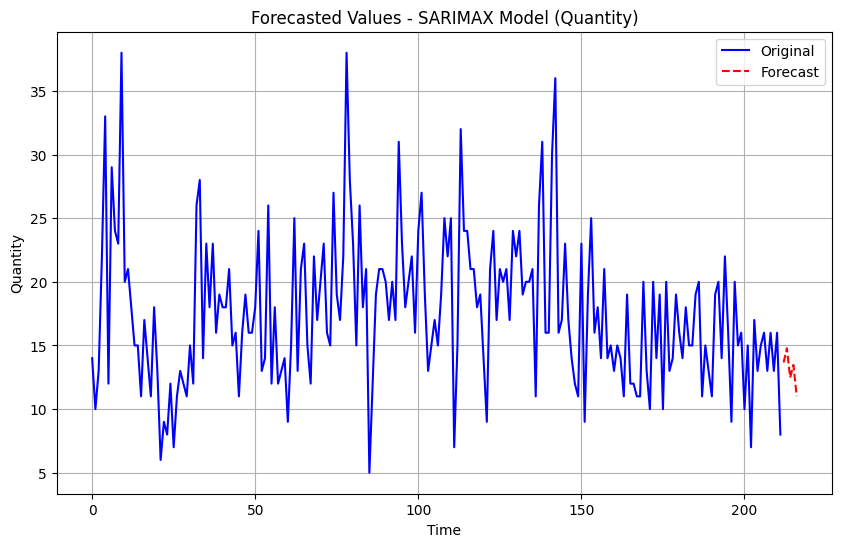

In [7]:
# Step 8: Display forecast results
future_index = range(len(time_series_diff), len(time_series_diff) + forecast_steps)
plt.figure(figsize=(10, 6))
plt.plot(time_series_diff, label="Original", color="blue")
plt.plot(future_index, forecast, label="Forecast", color="red", linestyle="--")
plt.title(f"Forecasted Values - SARIMAX Model ({target_column})")
plt.xlabel("Time")
plt.ylabel(target_column)
plt.legend()
plt.grid()
plt.show()